## Import Libraries

In [3]:
# importing data
import pandas as pd

# train_test_split & cross validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

# creating piplines
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

# machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# making graphs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

## Import Data

In [4]:
df = pd.read_pickle('run_pass_df.pkl')

In [5]:
df.head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,Target
3,80.0,900.0,1800.0,3600.0,1.0,1,1.0,0,15,10.0,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,1
4,70.0,862.0,1762.0,3562.0,1.0,1,2.0,0,5,11.0,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,0
5,59.0,826.0,1726.0,3526.0,1.0,1,1.0,0,10,20.0,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,0
6,39.0,790.0,1690.0,3490.0,1.0,1,1.0,0,10,0.0,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,1
7,39.0,785.0,1685.0,3485.0,1.0,1,2.0,0,10,0.0,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,1


In [6]:
# drop yards_gained feature as we are only interested in pre-snap information
df = df.drop('yards_gained', axis=1)

## Prepare Data

In [7]:
# prepare for the train_test_split
X = df.drop('Target', axis=1)
y = df.Target

In [8]:
# perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.20)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68998, 17), (17250, 17), (68998,), (17250,))

## Making Pipelines

In [10]:
# let's create a pipeline to do all of our preprocessing for us

In [11]:
preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
                                       (StandardScaler(), make_column_selector(dtype_include=np.number)))

# SMOTE() -> removed SMOTE from preprocessing pipeline

preprocessing

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])

In [12]:
# fit and transform our preprocessing pipeline to our training data
preprocessing.fit_transform(X_train)

array([[ 0.90564106,  0.85277944,  1.32850403, ...,  0.8464257 ,
        -1.80343225, -1.5457903 ],
       [ 0.74100312,  0.31975379,  1.0627638 , ..., -0.51012371,
        -0.49756381, -0.42533752],
       [ 0.98796002,  0.60107288, -0.45786081, ...,  2.10607873,
        -1.43032698, -1.62342321],
       ...,
       [ 0.0824514 ,  0.31235066,  1.05907297, ...,  0.74952932,
        -0.49756381, -0.56399903],
       [ 0.98796002, -0.60193639,  0.60325467, ...,  1.04021848,
        -0.77739276, -1.20649511],
       [ 0.78216261, -0.62414579,  0.59218216, ..., -0.21943455,
        -0.77739276, -0.87185151]])

In [13]:
# the next thing we'll do is make separate pipelines for each model we want to test
# each of these pipelines will contain our preprocessing pipeline

dt_pipeline = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=2020))
rf_pipeline = make_pipeline(preprocessing, RandomForestClassifier(random_state=2020))
lr_pipeline = make_pipeline(preprocessing, LogisticRegression(random_state=2020))
et_pipeline = make_pipeline(preprocessing, ExtraTreesClassifier(random_state=2020))
kn_pipeline = make_pipeline(preprocessing, KNeighborsClassifier())

## Create Param_Grids

In [14]:
# different param_grids for each pipeline

dt_param_grid = {
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [2, 5, 10],
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'decisiontreeclassifier__class_weight': ['none', 'balanced']
    
}

rf_param_grid = {
    'randomforestclassifier__n_estimators': [100, 1000, 2000],
    'randomforestclassifier__max_depth': [2, 5, 10]
    
}

lr_param_grid = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__dual': [True, False],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__multi_class': ['auto', 'ovr', 'multinomial'],
    'logisticregression__n_jobs': [10, 20, 30],
    'logisticregression__C': [0.01, 0.1, 0.5]
    
}

et_param_grid = {
    'extratreesclassifier__criterion': ['entropy', 'gini'],
    'extratreesclassifier__max_depth': [2, 5, 10],
    'extratreesclassifier__n_estimators': [100, 250, 500],
    'extratreesclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'extratreesclassifier__class_weight': ['none', 'balanced']
    
}

kn_param_grid = {
    'kneighborsclassifier__n_neighbors': [2, 3], # could increase values
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
    
}

## LogisticRegression

In [15]:
search_lr = GridSearchCV(lr_pipeline, lr_param_grid, n_jobs=-1)

search_lr.fit(X_train, y_train)

/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])),
                                       ('logisticregression',
                                        L...20))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 0.5],
                         'logisticregression__dual

In [16]:
# we can check its best parameters
search_lr.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__dual': True,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': 10,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [17]:
# assign best model to a variable using best_estimator_
best_lr_pipeline = search_lr.best_estimator_

In [18]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_lr_cross_val_acc = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='accuracy')
best_lr_cross_val_prec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='precision')
best_lr_cross_val_rec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='recall')
best_lr_cross_val_f1 = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='f1')

/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does n

## DecisionTree

In [19]:
search_dt = GridSearchCV(dt_pipeline, dt_param_grid, n_jobs=-1)

search_dt.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__class_weight': ['none',
      

In [20]:
# we can check its best parameters
search_dt.best_params_

{'decisiontreeclassifier__class_weight': 'balanced',
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 2,
 'decisiontreeclassifier__max_features': 'auto',
 'decisiontreeclassifier__splitter': 'random'}

In [21]:
# assign best model to a variable using best_estimator_
best_dt_pipeline = search_dt.best_estimator_

In [22]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_dt_cross_val_acc = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='accuracy')
best_dt_cross_val_prec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='precision')
best_dt_cross_val_rec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='recall')
best_dt_cross_val_f1 = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='f1')

## RandomForest

In [23]:
search_rf = GridSearchCV(rf_pipeline, rf_param_grid, n_jobs=-1)

search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [2, 5, 10],
      

In [24]:
# we can check its best parameters
search_rf.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 2000}

In [25]:
# assign best model to a variable using best_estimator_
best_rf_pipeline = search_rf.best_estimator_

In [26]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_rf_cross_val_acc = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='accuracy')
best_rf_cross_val_prec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='precision')
best_rf_cross_val_rec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='recall')
best_rf_cross_val_f1 = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='f1')

## ExtraTrees

In [27]:
search_et = GridSearchCV(et_pipeline, et_param_grid, n_jobs=-1)

search_et.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])),
                                       ('extratreesclassifier',
                                        ExtraTreesClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'extratreesclassifier__class_weight': ['none',
            

In [28]:
# we can check its best parameters
search_et.best_params_

{'extratreesclassifier__class_weight': 'balanced',
 'extratreesclassifier__criterion': 'gini',
 'extratreesclassifier__max_depth': 5,
 'extratreesclassifier__max_features': 'auto',
 'extratreesclassifier__n_estimators': 100}

In [29]:
# assign best model to a variable using best_estimator_
best_et_pipeline = search_et.best_estimator_

In [30]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_et_cross_val_acc = cross_val_score(best_et_pipeline, X_train, y_train, scoring='accuracy')
best_et_cross_val_prec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='precision')
best_et_cross_val_rec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='recall')
best_et_cross_val_f1 = cross_val_score(best_et_pipeline, X_train, y_train, scoring='f1')

## KNeighbors

In [31]:
search_kn = GridSearchCV(kn_pipeline, kn_param_grid, n_jobs=-1)

search_kn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd36d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f68dd32e0>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [2, 3],
                         'kneig

In [32]:
# we can check its best parameters
search_kn.best_params_

{'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [33]:
# assign best model to a variable using best_estimator_
best_kn_pipeline = search_kn.best_estimator_

In [34]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_kn_cross_val_acc = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='accuracy')
best_kn_cross_val_prec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='precision')
best_kn_cross_val_rec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='recall')
best_kn_cross_val_f1 = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='f1')

## Gaussian Naive Bayes

In [35]:
gaussian = GaussianNB()
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
gaussian.fit(X_train_sc, y_train)
# y_hat_train_gnb = gaussian.predict(X_train_sc)

GaussianNB()

In [36]:
# gnb_acc = accuracy_score(y_train, y_hat_train_gnb)
# gnb_prec = precision_score(y_train, y_hat_train_gnb)
# gnb_rec = recall_score(y_train, y_hat_train_gnb)
# gnb_f1 = f1_score(y_train, y_hat_train_gnb)

In [37]:
gnb_cross_val_acc = cross_val_score(gaussian, X_train_sc, y_train, scoring='accuracy').mean()
gnb_cross_val_prec = cross_val_score(gaussian, X_train_sc, y_train, scoring='precision').mean()
gnb_cross_val_rec = cross_val_score(gaussian, X_train_sc, y_train, scoring='recall').mean()
gnb_cross_val_f1 = cross_val_score(gaussian, X_train_sc, y_train, scoring='f1').mean()

## XGBoost

In [38]:
xgb = xgb.XGBClassifier()

xgb.fit(X_train_sc, y_train)
#y_hat_train_xgb = xgb.predict(X_train_sc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
# xgb_acc = accuracy_score(y_train, y_hat_train_xgb)
# xgb_prec = precision_score(y_train, y_hat_train_xgb)
# xgb_rec = recall_score(y_train, y_hat_train_xgb)
# xgb_f1 = f1_score(y_train, y_hat_train_xgb)

In [40]:
xgb_cross_val_acc = cross_val_score(xgb, X_train_sc, y_train, scoring='accuracy').mean()
xgb_cross_val_prec = cross_val_score(xgb, X_train_sc, y_train, scoring='precision').mean()
xgb_cross_val_rec = cross_val_score(xgb, X_train_sc, y_train, scoring='recall').mean()
xgb_cross_val_f1 = cross_val_score(xgb, X_train_sc, y_train, scoring='f1').mean()

## Comparison of Models

In [41]:
models = pd.DataFrame({
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 
              'ExtraTrees', 'KNeighbors', 'Gaussian Naive Bayes', 'XGBoost'], 
    'Accuracy': [best_lr_cross_val_acc.mean(), best_dt_cross_val_acc.mean(), best_rf_cross_val_acc.mean(), 
               best_et_cross_val_acc.mean(), best_kn_cross_val_acc.mean(), gnb_cross_val_acc, xgb_cross_val_acc], 
    'Precision': [best_lr_cross_val_prec.mean(), best_dt_cross_val_prec.mean(), best_rf_cross_val_prec.mean(), 
               best_et_cross_val_prec.mean(), best_kn_cross_val_prec.mean(), gnb_cross_val_prec, xgb_cross_val_prec], 
    'Recall': [best_lr_cross_val_rec.mean(), best_dt_cross_val_rec.mean(), best_rf_cross_val_rec.mean(), 
               best_et_cross_val_rec.mean(), best_kn_cross_val_rec.mean(), gnb_cross_val_rec, xgb_cross_val_rec],
    'F1 Score': [best_lr_cross_val_f1.mean(), best_dt_cross_val_f1.mean(), best_rf_cross_val_f1.mean(), 
               best_et_cross_val_f1.mean(), best_kn_cross_val_f1.mean(), gnb_cross_val_f1, xgb_cross_val_f1]}) 

In [42]:
models.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
2,RandomForest,0.743732,0.788520,0.806141,0.797228
6,XGBoost,0.741964,0.785458,0.807718,0.796431
3,ExtraTrees,0.736340,0.783292,0.799230,0.791172
1,DecisionTree,0.733094,0.776510,0.804448,0.790225
0,LogisticRegression,0.730891,0.764162,0.823558,0.792742
5,Gaussian Naive Bayes,0.697122,0.776986,0.722813,0.748913
4,KNeighbors,0.695730,0.747307,0.775250,0.761017


In [43]:
models.sort_values('Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
2,RandomForest,0.743732,0.788520,0.806141,0.797228
6,XGBoost,0.741964,0.785458,0.807718,0.796431
3,ExtraTrees,0.736340,0.783292,0.799230,0.791172
5,Gaussian Naive Bayes,0.697122,0.776986,0.722813,0.748913
1,DecisionTree,0.733094,0.776510,0.804448,0.790225
0,LogisticRegression,0.730891,0.764162,0.823558,0.792742
4,KNeighbors,0.695730,0.747307,0.775250,0.761017


In [44]:
models.sort_values('F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
2,RandomForest,0.743732,0.788520,0.806141,0.797228
6,XGBoost,0.741964,0.785458,0.807718,0.796431
0,LogisticRegression,0.730891,0.764162,0.823558,0.792742
3,ExtraTrees,0.736340,0.783292,0.799230,0.791172
1,DecisionTree,0.733094,0.776510,0.804448,0.790225
4,KNeighbors,0.695730,0.747307,0.775250,0.761017
5,Gaussian Naive Bayes,0.697122,0.776986,0.722813,0.748913


In [45]:
models.sort_values('Recall', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.730891,0.764162,0.823558,0.792742
6,XGBoost,0.741964,0.785458,0.807718,0.796431
2,RandomForest,0.743732,0.788520,0.806141,0.797228
1,DecisionTree,0.733094,0.776510,0.804448,0.790225
3,ExtraTrees,0.736340,0.783292,0.799230,0.791172
4,KNeighbors,0.695730,0.747307,0.775250,0.761017
5,Gaussian Naive Bayes,0.697122,0.776986,0.722813,0.748913


## Final Model

In [46]:
# refit training data onto best model
best_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f6b59e160>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7f6b59ec10>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=2000,
                                        random_state=2020))])

In [47]:
rf_cross_val_acc_test = cross_val_score(best_rf_pipeline, X_test, y_test, scoring='accuracy').mean()
rf_cross_val_prec_test = cross_val_score(best_rf_pipeline, X_test, y_test, scoring='precision').mean()
rf_cross_val_rec_test = cross_val_score(best_rf_pipeline, X_test, y_test, scoring='recall').mean()
rf_cross_val_f1_test = cross_val_score(best_rf_pipeline, X_test, y_test, scoring='f1').mean()

In [49]:
final_model_comp = pd.DataFrame({
    'Model': ['RandomForest Train', 'RandomForest Test'], 
    'Accuracy': [best_rf_cross_val_acc.mean(), rf_cross_val_acc_test], 
    'Precision': [best_rf_cross_val_prec.mean(), rf_cross_val_prec_test], 
    'Recall': [best_rf_cross_val_rec.mean(), rf_cross_val_rec_test],
    'F1 Score': [best_rf_cross_val_f1.mean(), rf_cross_val_f1_test]}) 

In [50]:
final_model_comp

,Model,Accuracy,Precision,Recall,F1 Score
0,RandomForest Train,0.743732,0.788520,0.806141,0.797228
1,RandomForest Test,0.740232,0.785132,0.802681,0.793770


## RandomForest Feature Importance

In [51]:
feat_imp_df = pd.DataFrame(best_rf_pipeline.steps[1][1].feature_importances_.round(decimals=3), index=X_train.columns)

In [52]:
feat_imp_df.rename({0: 'Importance'}, axis=1, inplace=True)

In [53]:
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

In [54]:
feat_imp_df

,Importance
goal_to_go,0.002
no_huddle,0.005
defteam_timeouts_remaining,0.005
posteam_timeouts_remaining,0.008
qtr,0.009
drive,0.014
posteam_score,0.014
defteam_score,0.019
yardline_100,0.026
quarter_seconds_remaining,0.026


<ipython-input-101-62ba9ed3a64c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feat_imp_df.index, fontsize=15)
<ipython-input-101-62ba9ed3a64c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feat_imp_df.Importance, fontsize=15)


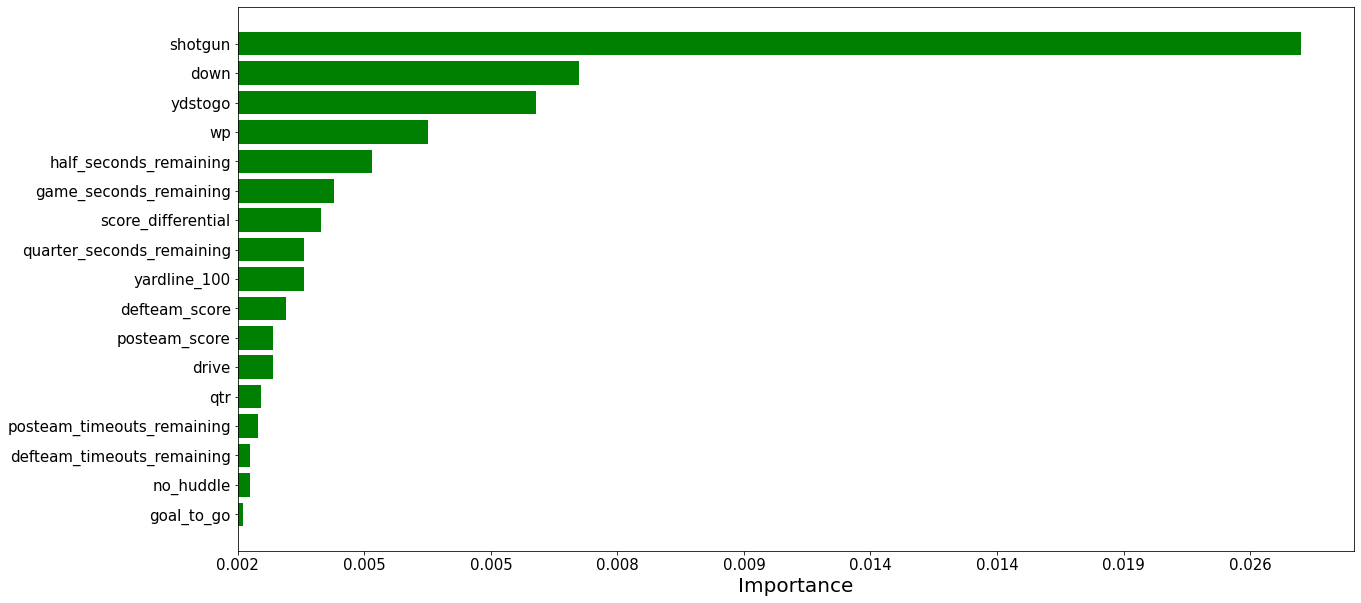

In [101]:
fig,ax = plt.subplots(figsize=(20,10))
plt.barh(feat_imp_df.index, feat_imp_df.Importance, color='g')
#plt.title('Run/Pass Feature Importance', fontsize=25)
plt.xlabel('Importance', fontsize=20)
ax.set_yticklabels(feat_imp_df.index, fontsize=15)
ax.set_xticklabels(feat_imp_df.Importance, fontsize=15)

plt.savefig('run_pass_features_2.png')
plt.show()

NameError: name 'ax' is not defined

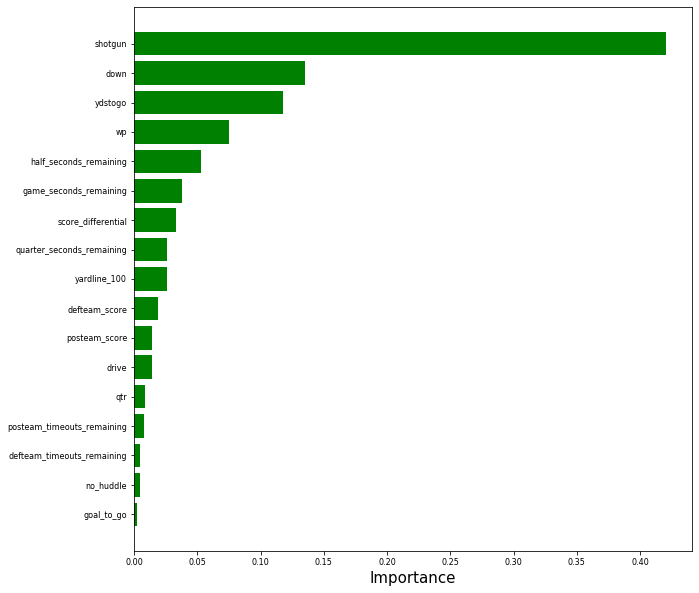

In [72]:
plt.figure(figsize=(10,10))
plt.barh(feat_imp_df.index, feat_imp_df.Importance, color='g')
plt.xlabel('Importance', fontsize=15)
#plt.title('Run/Pass Feature Importance', fontsize=20)

plt.savefig('run_pass_features.png')
plt.show()

## Confusion Matrix

In [56]:
labels = ['pass', 'run']
cm = confusion_matrix(y_test, pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'pred' is not defined

In [69]:
y_hat_test_rf = best_rf_pipeline.predict(X_test)

In [73]:
labels = ['run', 'pass']
run_pass_cm = confusion_matrix(y_test, y_hat_test_rf)
print(run_pass_cm)

[[4099 2407]
 [2076 8668]]


<ipython-input-75-2d5f11670843>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-75-2d5f11670843>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


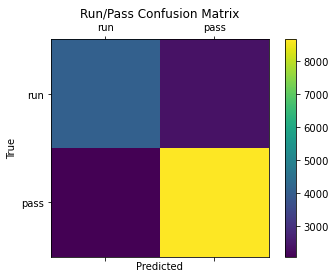

In [75]:
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(run_pass_cm)

plt.title('Run/Pass Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [107]:
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix_info(model, X_test, y_test, save_path=None):
    '''
    Creates a confusion matrix for a given model

    Parameters
    ----------
    model: an estimator

    X_test: testing dataset

    y_test: training dataset

    Returns
    -------
    A confusion matrix of given model
    '''
    fig, axes = plt.subplots(figsize=(10,5))

    #axes.set_title("Model Validation", fontsize=20)
    x_tick_marks = ['Predicted Run Play', 'Predicted Pass Play']
    y_tick_marks = ['Actual Run Play', 'Actual Pass Play']
    
    plot_confusion_matrix(model, X_test, y_test, ax=axes, cmap='Greens', display_labels=y_tick_marks)

    plt.xticks([0,1], x_tick_marks)
    axes.set_xlabel('')
    axes.set_ylabel('')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('font', size=SMALL_SIZE)          
    plt.rc('axes', titlesize=SMALL_SIZE)     
    plt.rc('axes', labelsize=MEDIUM_SIZE)    
    plt.rc('xtick', labelsize=SMALL_SIZE)   
    plt.rc('ytick', labelsize=SMALL_SIZE)   
    plt.rc('legend', fontsize=SMALL_SIZE)   
    plt.rc('figure', titlesize=BIGGER_SIZE)
    
    plt.tight_layout()
    confusion_matrix = plt.show()

    if save_path:
        plt.savefig(save_path, transparent=True)

    return confusion_matrix, fig



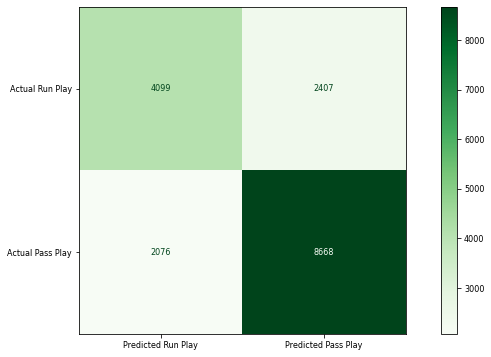

(None, <Figure size 720x360 with 2 Axes>)

<Figure size 432x288 with 0 Axes>

In [108]:
confusion_matrix_info(best_rf_pipeline, X_test, y_test, save_path='confusion_matrix.png')